# Celebrities Face Recognition

## In case models are not trained yet...

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K
from PIL import Image
from io import BytesIO
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# import cv2
import requests

In [3]:
print("TensorFlow:", tf.__version__)

TensorFlow: 2.0.0


In [4]:
cwd = os.getcwd()
print(os.listdir(cwd))

['.git', '.gitignore', '.ipynb_checkpoints', '.vscode', 'archive', 'chromedriver.exe', 'Clustering_and_PCA_FaceNet.ipynb', 'Clustering_and_PCA_OwnModels.ipynb', 'cnn.py', 'google_images.py', 'IMAGE', 'ImageGenerator&CNN.ipynb', 'ImageGenerator&CNN_2.ipynb', 'image_analysis.ipynb', 'pesos', 'README.md', 'results.py', '__pycache__']


In [5]:
train_data_dir=os.path.join(cwd, 'archive/data/train')
validation_data_dir=os.path.join(cwd,'archive/data/val')

resnet50weight=os.path.join(cwd,'archive/keras_pretrained_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
# vgg16weight=os.path.join(cwd,'archive/keras_pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

totalFilesTrain = 0
totalFilesVal = 0

### 1. Preparation of the data

In [6]:
for root, dirs, files in os.walk(train_data_dir):
    for name in files:
        (base, ext) = os.path.splitext(name) # split base and extension
        if ext in ('.jpg', '.png'):          # check the extension
            totalFilesTrain += 1

In [7]:
totalFilesTrain

135

In [8]:
for root, dirs, files in os.walk(validation_data_dir):
    for name in files:
        (base, ext) = os.path.splitext(name) # split base and extension
        if ext in ('.jpg', '.png'):          # check the extension
            totalFilesVal += 1

In [9]:
totalFilesVal

39

### 2. Data Augmentation

In [10]:
# The train_datagen corresponds to an augmentation tool which will enable us to generate
# images for our training dataset according to the configuration set.
train_datagen = ImageDataGenerator(rescale=1./255, # rescale enables us to normalize the images
                rotation_range=10,  # rotation_range randomly rotate images in the range between 0 and 10 degrees
                zoom_range = 0.1, # zoom_range zooms the images in the range from 0 to 0.1
                width_shift_range=0.1,  # width_shift_range randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # height_shift_range randomly shift images vertically (fraction of total height)
                vertical_flip=False, # vertical_flip allows us to unenable the flip of the image in the vertical axis
                horizontal_flip=True) # horizontal_flip allows us to enable the flip of the image in the horizontal axis
# The test_datagen corresponds to another augmentation tool which will enable us to generate 
# images for our validation dataset according to the configuration set.
# However, for this case only normalization of the images will be used
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
if os.path.isdir(cwd + '/archive/random_images') == False:
    os.makedirs(cwd + '/archive/random_images')
save_dir=os.path.join(cwd,'archive/random_images')


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_data_dir,
        # All images will be resized to 150x150
        target_size=(200, 200),
        # The size of the batches will be 30: the number of samples that will be propagated through the network
        batch_size=30,
        # The class mode will be binary: 1D numpy array of binary labels
        shuffle=True,class_mode='categorical',save_to_dir=save_dir,save_format="jpg")

validation_generator = test_datagen.flow_from_directory(
        # This is the target directory
        validation_data_dir,
        # All images will be resized to 150x150
        target_size=(200,200),
        # The size of the batches will be 30: the number of samples that will be propagated through the network
        batch_size=30,
        # The class mode will be binary: 1D numpy array of binary labels
        class_mode='categorical')

Found 135 images belonging to 7 classes.
Found 39 images belonging to 7 classes.


In [12]:
train_generator.samples 
validation_generator.samples

39

### 3. Testing of Data Augmentation Technique

(30, 200, 200, 3)
(30, 7)


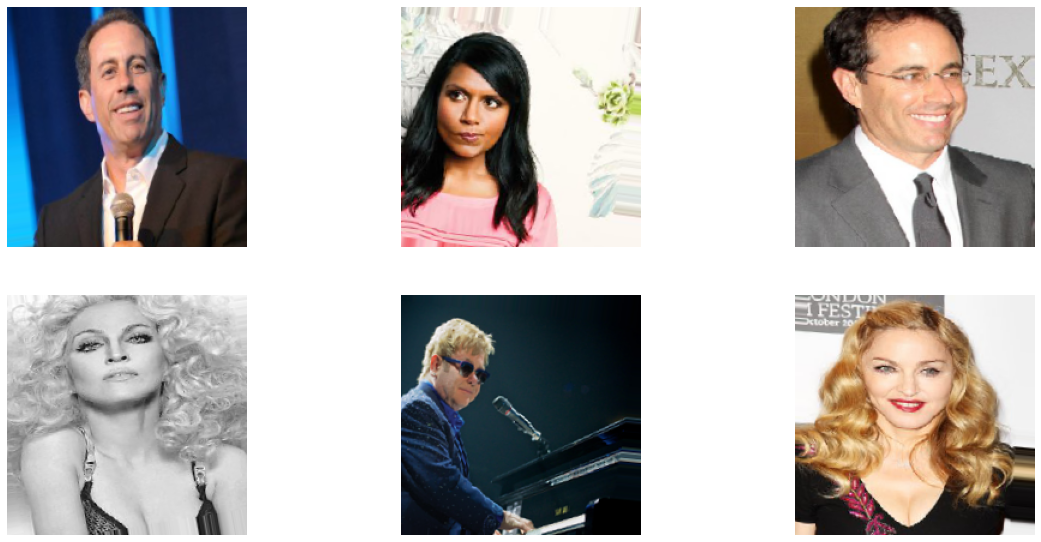

In [13]:
# from matplotlib import plt
batch=next(train_generator) # returns the next batch of images and labels
print(batch[0].shape)# batch[0] is the images shape
print(batch[1].shape)
fig = plt.figure(figsize=(20, 15))

for i in range(6):
    #batch=next(train_generator) # returns the next batch of images and labels 
    # define subplot
    fig.add_subplot(330 + 1 + i)
    # generate batch of images
    # convert to unsigned integers for viewing
    image = batch[0][i]
    plt.imshow(image)
    # plot raw pixel data
    #plt.imshow(image)
    plt.axis("off")
    # show the figure
plt.show()

### 4. Pretrained CNNs

In [14]:
def resnet50tl(input_shape, outclass, sigma='sigmoid'):
    
    base_model = None
    base_model = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(resnet50weight)
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model

In [15]:
def vgg16CNNtl(input_shape, outclass, sigma='sigmoid', dropout: float = 0.5, vgg16weight: str = 'archive/keras_pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'):
    base_model = None
    base_model = keras.applications.VGG16(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(vgg16weight)
        
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(dropout))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model

### 5. Preparation of images to enter the Networks

In [16]:
img_width, img_height = 200,200
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [16]:
input_shape
numclasses=batch[1].shape[1]

### 6. VGG16 CNN

### - First model 0.5 DROPOUT

#### 6.1 Training VGG16 CNN

In [17]:
model = vgg16CNNtl(input_shape, numclasses, 'softmax')
lr = 1e-5 #learning rate 
decay = 1e-7 #decay
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',  
              optimizer=optimizer,
              metrics=['accuracy']) 
#As we are dealing with multiple classes the loss will be given by the categorical_crossentropy loss function and the activation function will be softmax since it will assing a probability to each of the classes.

In [ ]:
#Parameters that will be uset to train our model VGG16
nb_train_samples=totalFilesTrain
nb_validation_samples=totalFilesVal
batch_size=30
epochs=50

In [ ]:
#Model fit 
history = model.fit(train_generator, 
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size)

#### 6.2. Ploting results

In [ ]:
import seaborn as sns
sns.set(font_scale=2)

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(20, 10))
# Visualize loss history
fig.add_subplot(121)
sns.lineplot(epoch_count, training_loss)
sns.lineplot(epoch_count, training_acc)
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')
plt.title('Training Loss/Accuracy vs Epoch',weight='bold')

# Get training and test loss histories
val_acc = history.history['val_accuracy']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
sns.lineplot(epoch_count, val_acc)
sns.lineplot(epoch_count, training_acc)
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch',weight='bold')

plt.savefig('model_dropout05_Results.png')
plt.show()

#### 6.3 Saving of the results

In [ ]:
#Weights will be saved in a .h5 file
saveweight1 =  'celebrities_weights_dropout_05.h5'
model1="model_dropout_05.h5"
model.save_weights(saveweight1)
model.save(model1)
###top_model.add(Dense(4096, activation='relu'))
###top_model.add(Dropout(0.5))
###batch_size=30
###epochs=50
###lr = 1e-5
###decay = 1e-7 #0.0

#### 6.4 Loading already trained models

In [ ]:
from keras.models import load_model
model = load_model('model_dropout_05.h5')

### 7. Examine functioning of the Neural Network

In [ ]:
labels = ['barack_obama','ben_afflek','elton_john','dwayne_johnson','jerry_seinfeld','madonna','mindy_kaling']
test_images=[]
for root, dirs, files in os.walk(validation_data_dir):
    for name in files:
        test_images.append(root+'/'+name)
test_imgs=np.random.choice(test_images,8)
for test in test_imgs:
    fig, ax = plt.subplots()
    test_img = os.path.join(validation_data_dir, test)
    print(test_img)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100),size=16,weight='bold')
    ax.imshow(img)

### - Second model 0.2 DROPOUT

#### 6.1 Training VGG16 CNN

In [ ]:
def vgg16CNNtl(input_shape, outclass, sigma='sigmoid'):
    base_model = None
    base_model = keras.applications.VGG16(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(vgg16weight)
        
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.2))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model

In [ ]:
model = vgg16CNNtl(input_shape, numclasses, 'softmax')
lr = 1e-5 #learning rate 
decay = 1e-7 #decay
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',  
              optimizer=optimizer,
              metrics=['accuracy']) 
#As we are dealing with multiple classes the loss will be given by the categorical_crossentropy loss function and the activation function will be softmax since it will assing a probability to each of the classes.

In [ ]:
#Parameters that will be uset to train our model VGG16
nb_train_samples=totalFilesTrain
nb_validation_samples=totalFilesVal
batch_size=30
epochs=50

In [ ]:
#Model fit 
history = model.fit(train_generator, 
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size)


#### 6.2. Ploting results

In [ ]:
import seaborn as sns
sns.set(font_scale=2)

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(20, 10))
# Visualize loss history
fig.add_subplot(121)
sns.lineplot(epoch_count, training_loss)
sns.lineplot(epoch_count, training_acc)
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')
plt.title('Training Loss/Accuracy vs Epoch',weight='bold')

# Get training and test loss histories
val_acc = history.history['val_accuracy']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
sns.lineplot(epoch_count, val_acc)
sns.lineplot(epoch_count, training_acc)
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch',weight='bold')

plt.savefig('model_dropout02_Results.png')
plt.show()


#### 6.3 Saving of the results

In [ ]:
#Weights will be saved in a .h5 file
saveweight1 =  'celebrities_weights_dropout_02.h5'
model1="model_dropout_02.h5"
model.save_weights(saveweight1)
model.save(model1)
###top_model.add(Dense(4096, activation='relu'))
###top_model.add(Dropout(0.5))
###batch_size=30
###epochs=50
###lr = 1e-5
###decay = 1e-7 #0.0

#### 6.4 Loading already trained models

In [ ]:
from keras.models import load_model
model = load_model('model_dropout_02.h5')

## In case models are already trained...

### 1. Loading already trained models

In [ ]:
from keras.models import load_model
model = load_model('model_dropout_02.h5')

### 2. Check functioning of the Neural Network

In [ ]:
labels = ['barack_obama','ben_afflek','elton_john','dwayne_johnson','jerry_seinfeld','madonna','mindy_kaling']
test_images=[]
for root, dirs, files in os.walk(validation_data_dir):
    for name in files:
        test_images.append(root+'/'+name)
test_imgs=np.random.choice(test_images,6)

for test in test_imgs:
    fig, ax = plt.subplots()
    test_img =os.path.join(validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100),size=16,weight='bold')
    ax.imshow(img)